<h1><center>Laboratorio 8: Predicciones y Recomendaciones 🔮🪄 </center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### **Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados**

- Nombre de alumno 1: Cristian Oyarzo M.
- Nombre de alumno 2: Sebastián Quenti A.

### **Link de repositorio de GitHub:** [Repositorio](https://github.com/sebaquenti/Repositorio-MDS7202)

## Temas a tratar
- Series de Tiempo.
- Predicciones vía `Prophet`.
- Implementar un sistema de recomendación utilizando `surprise`.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio
- Comprender qué es una serie de tiempo y su estructura.
- Identificar tendencias, estacionalidades e irregularidades.
- Armar un modelo predictivo para la serie.
- Conocer y aplicar sistemas de recomendación.
- Entender estructura y conocer casos de estudio.


In [1]:
# Librerias globales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

# **1. Forecasting (30 puntos)**


## **Prophet**

Prophet es una herramienta open-source de Facebook utilizada para realizar predicciones en series de tiempo. Esta se basa en la descomposición aditiva, donde tendencias no lineales se ajustan junto a la estacionalidad.

En la ecuación de a continuación se puede ver una idea general de los elementos que construyen a un modelo aditivo como lo es Prophet.

\begin{equation}
y(t) = g(t) + s(t) + h(t) + e(t)
\end{equation}

Donde, $g(t)$ hace referencia a las tendencias, que corresponden a cambios graduales en largos periodos de tiempo. $s(t)$ corresponde a la estacionalidad, son cambios periodicos o cortos en el tiempo. $h(t)$ es el efecto que tienen las festividades sobre las predicciones, mientras que e(t) corresponde al error o ruido. Finalmente $y(t)$, es la predicción hecha por el modelo.

Prophet trabaja por defecto con Piece-Wise Lineal Model, este es un modelo de regresión lineal, en el cual se buscan distintas zonas en que la data presente patrones o tendencias lineales, de estas zonas obtiene su regresión y luego las "une" de manera de representar toda la región, como se puede ver en la ecuación siguiente.

\begin{equation}
y(x)=
    \begin{cases}
        η_1 + \beta_1(x-b_1), & b_1 < x  \leqslant b_2 \\
        η_2 + \beta_2(x-b_2), & b_2 < x  \leqslant b_3 \\
        η_3 + \beta_3(x-b_3), & b_3 < x  \leqslant b_3 \\
        ... \\
        η_k + \beta_{nb}(x-b_{nb-1}), & b_{n-1} < x  \leqslant b_{nb} \\
    \end{cases}
\end{equation}

Siendo $b_1$ el primer punto de quiebre en la serie y así hasta el punto $b_{nb}$ correspondiente al último punto de quiebre de la serie con una cantidad $nb$ de puntos.

Para mayor información de Prophet y como utilizarla, pueden ver su [documentación](https://facebook.github.io/prophet/docs/quick_start.html#python-api), donde hay pueden encontrar un pequeño tutorial de la librería.

## **La Factura de Homero**

<center>
<img src ="https://i.makeagif.com/media/7-30-2018/H_ZAY1.gif" width = 500 />

Homero Simpson ha trabajado en la Planta Nuclear de Springfield por más de 20 años como Inspector de Seguridad, pero recientemente el Sr. Burns le ha permitido trabajar desde casa. Aunque le encanta la flexibilidad que esto le otorga, también ha notado un aumento considerable en su consumo energético en el hogar. Con el uso constante de calefacción en invierno y aire acondicionado en verano, Homero está preocupado por cómo afectará esto a su presupuesto en los próximos meses, ya que planea pasar aún más tiempo en casa.

Afortunadamente, gracias a su puesto en la Planta de Energía Nuclear, Homero tiene acceso a los datos de consumo de energía de cada ciudadano en Springfield, por lo que accede a esta información y almacena el consumo de su hogar en un archivo llamado `energia_homero.csv`. Este archivo posee el consumo diario en el hogar de Homero Simpson desde el Junio del 2016 hasta Julio del 2020.

Con esta valiosa información, Homero espera poder predecir su consumo energético y tomar decisiones informadas para ajustar su presupuesto mensual.

Los datos son los siguientes:

* **date**: Fecha de medición.
* **Energy_kWh**: Consumo diario de energía eléctrica en el hogar de Homero (en kWh).

## 1.1 Series de Tiempo [0 puntos]

### Carga de los datos

En primer lugar, cargue los datos históricos del archivo `energia_homero.csv` al entorno de trabajo. Una vez cargados, asegúrense de transformar la columna `date` a formato `datetime`. Además, visualice el consumo de energía en la casa de Homero mediante la librería `plotly`.


**Respuesta**:

In [2]:
df = pd.read_csv("/energia_homero.csv")

In [3]:
# Transformar la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Visualización del consumo de energía usando Plotly
fig = px.line(df, x='date', y='Energy_kWh', title='Consumo de Energía en la Casa de Homero Simpson (2016-2020)',
              labels={'date': 'Fecha', 'consumo': 'Consumo Energético (kWh)'})

# Mostrar la gráfica
fig.show()

## 1.2 Controlando la Serie de Tiempo [6 puntos]

<center>
<img src ="https://i.pinimg.com/originals/66/77/88/667788e0b1f08ff1e1cfce11d303b203.gif" width = 500 />

Luego de leer mucho, Homero cree que necesita descomponer la serie de tiempo para poder controlar estos componentes de forma efectiva y lograr que la serie tenga propiedades de una serie estacionaria.

Usted, como buen ciudadano de Springfield, decide ayudar a Homero, el cual le pide que realice lo siguientes pasos:

0. Cree un conjunto de entrenamiento y uno de prueba (a proyectar). Para ello, considere como entrenamiento la información **hasta** el `2020-02-29` y como conjunto de prueba **desde** el `2020-03-01`. [0 puntos]
1. Cree un `Pipeline` que permita obtener una representación de la tendencia de la serie de tiempo, mediante un modelo Lineal. Nombre al pipeline `Pipeline_trend`. [1 punto]
2. Entrene el modelo lineal y luego obtenga predicciones tanto para el conjunto de entrenamiento como para el de prueba (intervalo completo de tiempo). Luego grafique las predicciones y calcule el `Mean Absolute Error` (MAE), tanto para el conjunto de prueba como para el de entrenamiento. [1 punto]
3. Grafique el error (Valor real - Valor predicho) para todo el intervalo de tiempo y responda ¿Hay un comportamiento estacional en la serie? [1 punto]
4.  Cree un `Pipeline` que permita modelar la estacionalidad de la serie temporal mediante términos de Fourier y la represente a través de una Regresión Lineal de la variable objetivo. Nombre a este pipeline `Pipeline_seasonal`. Determine el valor de Periodos `P` y el número de terminos de Fourier `n`. [1 punto]
5. Entrene el nuevo modelo y obtenga predicciones en el intervalo completo de tiempo. Luego grafique y calcule el `MAE` en el conjunto de prueba y en el de entrenamiento. [1 punto]
6. Vuelva a graficar el error y comente los resultados. [1 punto]

**Respuesta**

In [4]:
# Parte 0
# Definir el límite de corte para el entrenamiento
fecha_corte = '2020-02-29'

# Conjunto de entrenamiento
df_train = df[df['date'] <= fecha_corte]

# Conjunto de prueba
df_test = df[df['date'] > fecha_corte]

# Mostrar la cantidad de datos en cada conjunto
print(f"Datos de entrenamiento: {len(df_train)} registros")
print(f"Datos de prueba: {len(df_test)} registros")

Datos de entrenamiento: 1369 registros
Datos de prueba: 129 registros


In [5]:
# Parte 1
# Crear el pipeline
Pipeline_trend = Pipeline(steps=[
    ('regressor', LinearRegression())
])

# Índice
df_train.loc[:, 'day_number'] = np.arange(len(df_train))

# Entrenar el Pipeline
X_train = df_train[['day_number']]
y_train = df_train['Energy_kWh']

Pipeline_trend.fit(X_train, y_train)

# Predicciones de tendencia en el conjunto de entrenamiento
df_train.loc[:, 'trend'] = Pipeline_trend.predict(X_train)

# Visualización de la tendencia junto con el consumo original
fig = px.line(df_train, x='date', y=['Energy_kWh', 'trend'],
              labels={'value': 'Consumo Energético (kWh)', 'variable': 'Serie'},
              title='Consumo Energético y Tendencia Estimada (Modelo Lineal)')
fig.show()

In [6]:
# Parte 2
# Índice
df_test.loc[:, 'day_number'] = np.arange(len(df_train), len(df_train) + len(df_test))

# Predicciones para el conjunto de prueba
X_test = df_test[['day_number']]
y_test = df_test['Energy_kWh']

# Obtener predicciones para el conjunto de entrenamiento
df_train.loc[:, 'trend'] = Pipeline_trend.predict(X_train)

# Obtener predicciones para el conjunto de prueba
df_test.loc[:, 'trend'] = Pipeline_trend.predict(X_test)

# Calcular el MAE para ambos conjuntos
mae_train = mean_absolute_error(y_train, df_train['trend'])
mae_test = mean_absolute_error(y_test, df_test['trend'])

print(f"MAE en el conjunto de entrenamiento: {mae_train}")
print(f"MAE en el conjunto de prueba: {mae_test}")

# Concatenar los conjuntos de entrenamiento y prueba
df_full = pd.concat([df_train, df_test])

# Graficar las predicciones
fig = px.line(df_full, x='date', y=['Energy_kWh', 'trend'],
              labels={'value': 'Consumo Energético (kWh)', 'variable': 'Serie'},
              title='Consumo Energético y Predicciones del Modelo Lineal')
fig.show()

MAE en el conjunto de entrenamiento: 10.568154088025606
MAE en el conjunto de prueba: 8.655813997873521


In [7]:
# Parte 3
# Calcular el error
df_full['error'] = df_full['Energy_kWh'] - df_full['trend']

# Graficar el error a lo largo del tiempo
fig = px.line(df_full, x='date', y='error',
              labels={'date': 'Fecha', 'error': 'Error (kWh)'},
              title='Error (Valor Real - Valor Predicho) en el Consumo Energético')
fig.show()

# Calcular la desviación estándar del error en todo el conjunto
std_error_total = df_full['error'].std()

# Mostrar la desviación estándar
print(f"Desviación estándar del error en todo el conjunto: {std_error_total}")

Desviación estándar del error en todo el conjunto: 12.456095884737456


Si se observa estacionalidad en los errores, se puede notar que, cada año, alrededor del mes de julio, el modelo lineal tiende a subestimar el consumo energético. Esto ocurre porque el comportamiento lineal de la predicción no logra capturar los picos de consumo que se presentan en esa época del año.

Por otro lado, en los meses de enero ocurre lo contrario: el modelo sobreestima el consumo, lo que sugiere que la predicción lineal tampoco refleja adecuadamente las caídas de consumo de esa temporada.

In [8]:
# Parte 4
# Definir el transformador de Fourier
class FourierFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, period=365, n=3):
        self.period = period
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.reshape(-1)
        features = [np.ones(len(X))]  # Añadir intercepto
        for i in range(1, self.n + 1):
            features.append(np.sin(2 * np.pi * i * X / self.period))
            features.append(np.cos(2 * np.pi * i * X / self.period))
        return np.column_stack(features)

# Crear el Pipeline para la estacionalidad
Pipeline_seasonal = Pipeline(steps=[
    ('fourier', FourierFeatures(period=365, n=1)),  # Periodo de 1 año y 1 término de Fourier
    ('regressor', LinearRegression())
])

# Entrenamiento del modelo estacional
X_train_seasonal = df_train['day_number'].values.reshape(-1, 1)
y_train_seasonal = df_train['Energy_kWh']

Pipeline_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predicciones solo en el conjunto de entrenamiento
df_train.loc[:, 'seasonal'] = Pipeline_seasonal.predict(X_train_seasonal)

# Graficar las predicciones estacionales solo para el conjunto de entrenamiento
fig = px.line(df_train, x='date', y=['Energy_kWh', 'seasonal'],
              labels={'value': 'Consumo Energético (kWh)', 'variable': 'Serie'},
              title='Consumo Energético y Predicciones Estacionales (Conjunto de Entrenamiento)')
fig.show()


Se utilizó un período P de 1 año debido a la aparente estacionalidad anual del consumo energético, y se seleccionó n = 1 para capturar el comportamiento cíclico del consumo.

In [9]:
# Parte 5
# Entrenamiento del modelo estacional
X_train_seasonal = df_train['day_number'].values.reshape(-1, 1)
y_train_seasonal = df_train['Energy_kWh']

Pipeline_seasonal.fit(X_train_seasonal, y_train_seasonal)

# Predicciones en el conjunto de prueba
X_test_seasonal = df_test['day_number'].values.reshape(-1, 1)
df_test.loc[:, 'seasonal'] = Pipeline_seasonal.predict(X_test_seasonal)

# Graficar solo las predicciones estacionales en el conjunto de prueba
fig = px.line(df_test, x='date', y=['Energy_kWh', 'seasonal'],
              labels={'value': 'Consumo Energético (kWh)', 'variable': 'Serie'},
              title='Consumo Energético y Predicciones Estacionales (Conjunto de Prueba)')
fig.show()

# Calcular el MAE para el conjunto de entrenamiento
mae_train = mean_absolute_error(df_train['Energy_kWh'], df_train['seasonal'])
print(f"MAE en el conjunto de entrenamiento: {mae_train}")

# Calcular el MAE para el conjunto de prueba
mae_test = mean_absolute_error(df_test['Energy_kWh'], df_test['seasonal'])
print(f"MAE en el conjunto de prueba: {mae_test}")


MAE en el conjunto de entrenamiento: 5.984433554507631
MAE en el conjunto de prueba: 4.874153072485149


El gráfico del conjunto de entrenamiento está en la parte 4

In [10]:
# Parte 6
# Calcular el error para el conjunto de entrenamiento
df_train['error'] = df_train['Energy_kWh'] - df_train['seasonal']

# Calcular el error para el conjunto de prueba
df_test['error'] = df_test['Energy_kWh'] - df_test['seasonal']

# Concatenar los DataFrames de entrenamiento y prueba para el gráfico
df_train['set'] = 'Entrenamiento'
df_test['set'] = 'Prueba'

df_full = pd.concat([df_train, df_test])

# Graficar el error para ambos conjuntos en el mismo gráfico
fig = px.line(df_full, x='date', y='error', color='set',
              labels={'date': 'Fecha', 'error': 'Error (kWh)', 'set': 'Conjunto'},
              title='Error (Valor Real - Valor Predicho) en Entrenamiento y Prueba')
fig.show()

# Calcular la desviación estándar del error en todo el conjunto (entrenamiento y prueba combinados)
std_error_total = df_full['error'].std()

# Mostrar el resultado
print(f"Desviación estándar del error en todo el conjunto: {std_error_total}")

Desviación estándar del error en todo el conjunto: 7.954382800384006


Se puede observar que este modelo tiene una menor desviación estándar y pareciera capturar mejor la naturaleza de los datos. Aunque en torno al mes de julio se puede observar una mayor dispersión de los errores.

## 1.3 Un Consejo para Homero [6 puntos]

<center>
<img src ="https://media.tenor.com/sjbvGMLZiDkAAAAM/the-simpsons-homner-simpson.gif" width = 400 />

Homero al observar los resultados obtenidos, se mostró conforme y decidió no seguir averiguando al respecto. Usted, como buen amigo y utilizando sus recientes conocimientos en Forecast, le sugiere a Homero utilizar **Prophet**, una herramienta de modelado de series de tiempo que incluye descomposición de tendencias y estacionalidad, así como la capacidad de incorporar regresores adicionales. Usted le explica a Homero que Prophet es especialmente útil para realizar pronósticos cuando hay patrones estacionales y que podría mejorar los resultados que ha obtenido hasta ahora.

Homero, algo agotado debido al exhaustivo estudio que hizo para entender como funciona esta herramienta, le solicita ayuda para implementar Prophet y evaluar si puede obtener mejores resultados en sus predicciones de consumo energético.

Dado esto, Homero le pide que realice los siguientes pasos:

1. Instale y cargue Prophet a su entorno de trabajo. Luego renombre la variable temporal `date` por `ds` y la variable objetivo `Energy_kWh` por `y`, en los conjuntos de entrenamiento y de prueba. [1 punto]
2. Cree y ajuste el modelo Prophet con sus datos de entrenamiento. Luego realice prepare el dataset de predicciones con su set de prueba y realice las predicciones. `Nota:` Le puede ser útil este [Enlace](https://facebook.github.io/prophet/docs/quick_start.html#python-api) [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en todo el intervalo de tiempo. Analice sus resultados y responda: ¿Hay un comportamiento estacional en la serie? [1 punto]

In [11]:
# librerias extras
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

**Respuesta:**

In [12]:
# Parte 1
# Renombrar las columnas para Prophet en los conjuntos de entrenamiento y prueba
df_train_prophet = df_train.rename(columns={'date': 'ds', 'Energy_kWh': 'y'})
df_test_prophet = df_test.rename(columns={'date': 'ds', 'Energy_kWh': 'y'})

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/a1v2mqdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/b7t21akn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30346', 'data', 'file=/tmp/tmpqzmnz4h5/a1v2mqdv.json', 'init=/tmp/tmpqzmnz4h5/b7t21akn.json', 'output', 'file=/tmp/tmpqzmnz4h5/prophet_model5ojhj5l7/prophet_model-20241021020950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:09:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:09:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


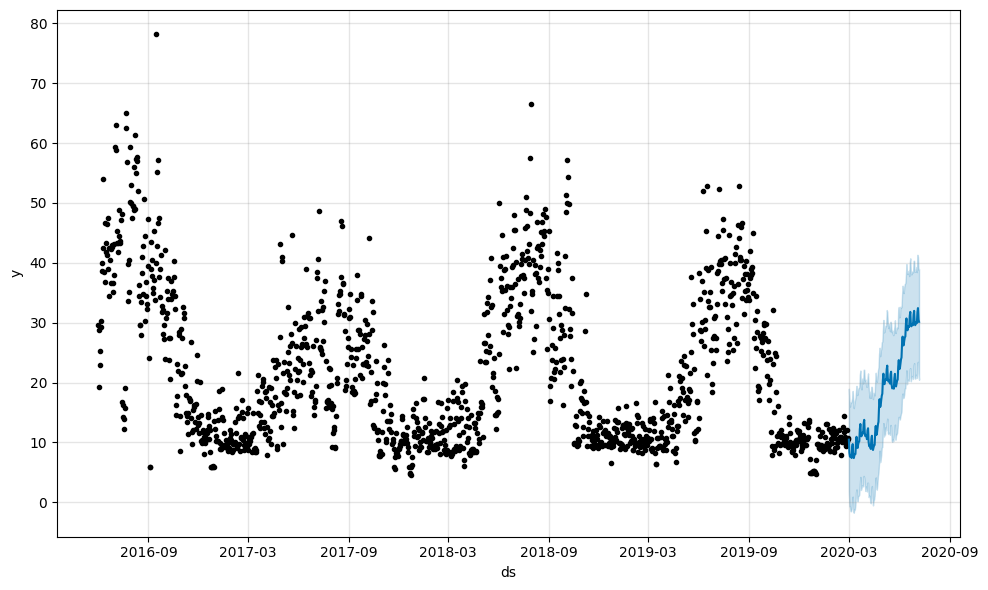

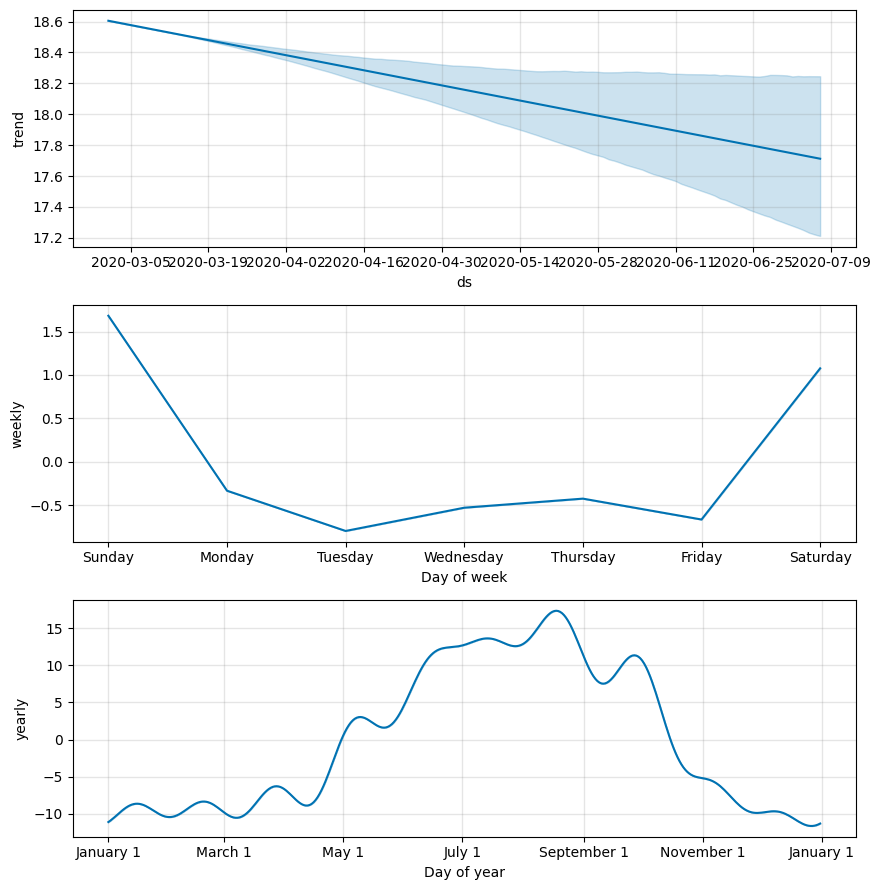

In [13]:
# Parte 2 y 3
# Crear el modelo Prophet
m = Prophet()

# Ajustar el modelo con los datos de entrenamiento
m.fit(df_train_prophet)

# Preparar el conjunto de prueba para las predicciones
future = df_test_prophet[['ds']]

# Realizar las predicciones
forecast = m.predict(future)

# Graficar las predicciones utilizando el método `.plot()`
fig1 = m.plot(forecast)
fig1.show()

# Graficar las componentes (tendencia, estacionalidad) utilizando `.plot_components()`
fig2 = m.plot_components(forecast)
fig2.show()

In [14]:
# Parte 4
# Realizar las predicciones en el conjunto de entrenamiento
future_train = df_train_prophet[['ds']]
forecast_train = m.predict(future_train)

# Calcular el MAE para el conjunto de entrenamiento
mae_train = mean_absolute_error(df_train_prophet['y'], forecast_train['yhat'])
print(f"MAE en el conjunto de entrenamiento: {mae_train}")

# Calcular el MAE para el conjunto de prueba
mae_test = mean_absolute_error(df_test_prophet['y'], forecast['yhat'])
print(f"MAE en el conjunto de prueba: {mae_test}")

MAE en el conjunto de entrenamiento: 4.817481017717443
MAE en el conjunto de prueba: 4.921079315201517


In [15]:
# Parte 5
# Calcular el error para el conjunto de entrenamiento
df_train_prophet['error'] = df_train_prophet['y'] - forecast_train['yhat']

# Calcular el error para el conjunto de prueba
df_test_prophet['error'] = df_test_prophet['y'] - forecast['yhat']

# Concatenar los DataFrames de entrenamiento y prueba
df_full_prophet = pd.concat([df_train_prophet, df_test_prophet])

# Graficar el error en todo el intervalo de tiempo
fig = px.line(df_full_prophet, x='ds', y='error',
              labels={'ds': 'Fecha', 'error': 'Error (kWh)'},
              title='Error (Valor Real - Valor Predicho) en todo el Intervalo de Tiempo')
fig.show()

# Calcular la desviación estándar del error en todo el conjunto (entrenamiento y prueba combinados)
std_error_total = df_full_prophet['error'].std()

# Mostrar la desviación estándar del error
print(f"Desviación estándar del error en todo el conjunto: {std_error_total}")

Desviación estándar del error en todo el conjunto: 6.880421990066616


La desviación estándar de los errores volvió a reducirse, lo que podría indicar que este modelo captura aún mejor el comportamiento de la data. Nuevamente hay indicios de estacionalidad al haber más dispersión de los errores en torno al mes de julio.

## 1.4 Incluyendo Regresores [5 puntos]

<center>
<img src ="https://i.redd.it/64hwjftunjjd1.gif" width = 400 />

Con los nuevos resultados obtenidos del modelo Prophet, usted le aconseja a Homero que puede mejorar sus predicciones al incluir regresores en el modelo, es decir, variables adicionales que pueden influir en la variable objetivo, en este caso, el consumo energético. Homero encuentra que es una buena idea y va en busca de ayuda donde el Profesor Frink, un destacado Científico de Springfield. Para suerte de Homero, Frink tenía un estudio reciente que registra las condiciones climáticas en Springfield, en el mismo intervalo de tiempo en que Homero disponía de los datos de consumo eléctrico. Con esta nueva información, usted le recomienda a Homero que podrían utilizar esta información meteorológica proporcionada como variables exógenas al modelo.

Sin embargo, al no comprender bien la importancia de los regresores, Homero decide confiar en sus capacidades y le pide que, por favor, incluya estas variables en el modelo para evaluar su impacto en las predicciones.

Para ello, usted debe:
0. Seleccionar las variables exógenas a utilizar del archivo `datos_frink.csv`. Añada estas variables a sus conjuntos de entrenamiento y prueba mediante `merge`. [0 puntos]
1. Cree el modelo Prophet e incluya los regresores (variables exógenas) al modelo. Luego realice el entrenamiento. **Hint**: Utilice el método `.add_regressor()`. Mas información en el siguiente [Enlace](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors). [2 puntos]
2. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
3. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. Analice sus resultados. [1 punto]
4. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y de prueba. ¿Hay un comportamiento estacional en la serie? ¿Influyen estas variables en el comportamiento del consumo energético en el hogar de Homero? [1 punto]

Los datos del dataset de Frink son los siguientes:

* **date**: Fecha de medición.
* **Temp_max**: Temperatura máxima registrada durante el día (en °F).
* **Temp_avg**: Temperatura promedio registrada durante el día (en °F).
* **Temp_min**: Temperatura mínima registrada durante el día (en °F).
* **Dew_max**: Punto de rocío máximo registrado durante el día (en °F).
* **Dew_avg**: Punto de rocío promedio registrado durante el día (en °F).
* **Dew_min**: Punto de rocío mínimo registrado durante el día (en °F).
* **Hum_max**: Humedad máxima registrada durante el día (en porcentaje).
* **Hum_avg**: Humedad promedio registrada durante el día (en porcentaje).
* **Hum_min**: Humedad mínima registrada durante el día (en porcentaje).
* **Wind_max**: Velocidad máxima del viento registrada durante el día (en millas por hora, mph).
* **Wind_avg**: Velocidad promedio del viento registrada durante el día (en millas por hora, mph).
* **Wind_min**: Velocidad mínima del viento registrada durante el día (en millas por hora, mph).
* **Press_max**: Presión atmosférica máxima registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_avg**: Presión atmosférica promedio registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_min**: Presión atmosférica mínima registrada durante el día (en pulgadas de mercurio, Hg).

**Respuesta:**

In [16]:
# Parte 0
df_frink = pd.read_csv('/datos_frink.csv')
df_frink = df_frink.rename(columns={'date': 'ds'})

# Formato datetime
df_train_prophet['ds'] = pd.to_datetime(df_train_prophet['ds'])
df_test_prophet['ds'] = pd.to_datetime(df_test_prophet['ds'])
df_frink['ds'] = pd.to_datetime(df_frink['ds'])

# Realizar el merge con los datos de entrenamiento y prueba usando la columna 'ds'
df_train = pd.merge(df_train_prophet, df_frink, on='ds')
df_test = pd.merge(df_test_prophet, df_frink, on='ds')

In [17]:
# Parte 1
# Crear el modelo Prophet e incluir los regresores
m = Prophet()

# Añadir los regresores
regresores_avg = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']

for reg in regresores_avg: # Se seleccionaron las variables promedio
    m.add_regressor(reg)

# Entrenar el modelo
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/0np4gpus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/keee0imj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77812', 'data', 'file=/tmp/tmpqzmnz4h5/0np4gpus.json', 'init=/tmp/tmpqzmnz4h5/keee0imj.json', 'output', 'file=/tmp/tmpqzmnz4h5/prophet_modelkukspuz0/prophet_model-20241021020955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


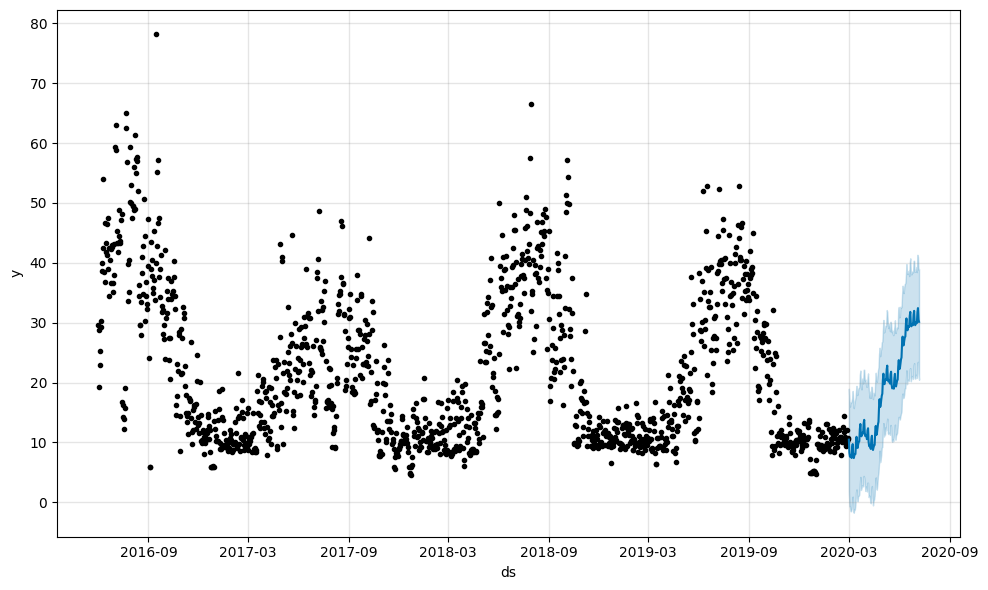

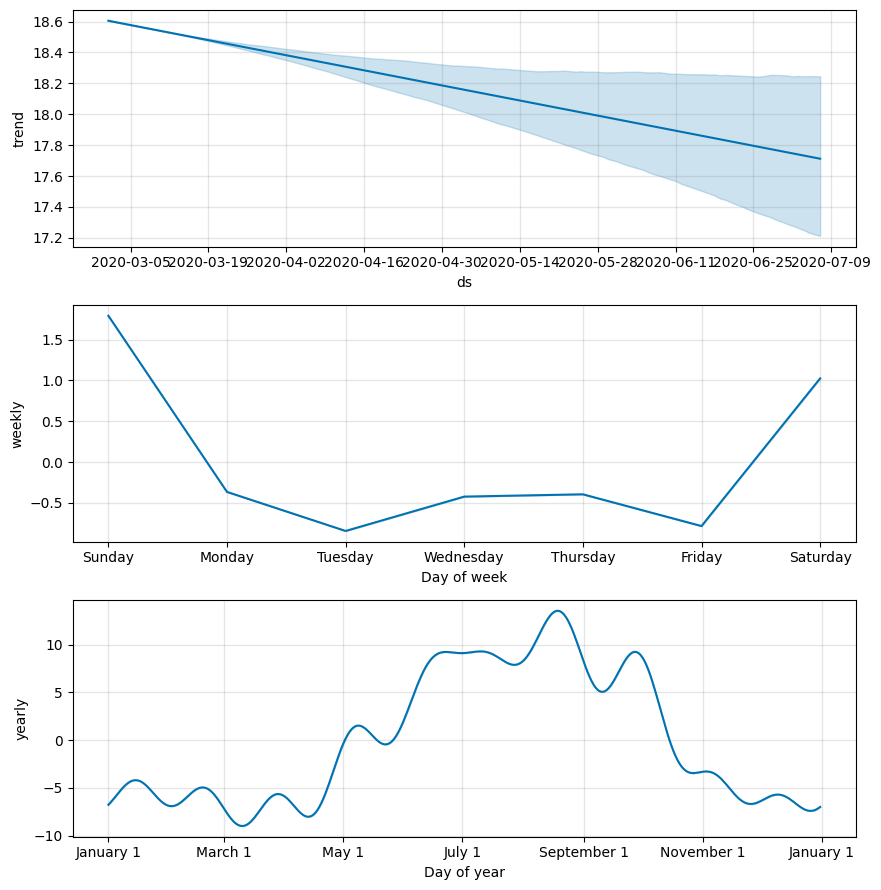

In [18]:
# Parte 2
# Graficar las predicciones
fig1 = m.plot(forecast)
fig1.show()

# Graficar las componentes del modelo
fig2 = m.plot_components(forecast)
fig2.show()


In [19]:
# Parte 3
regresores_avg = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']
# Seleccionar las columnas 'ds' y los regresores del conjunto de entrenamiento y prueba
future_train = df_train[['ds'] + regresores_avg]
future_test = df_test[['ds'] + regresores_avg]
forecast_train = m.predict(future_train)
forecast_test = m.predict(future_test)

# Calcular el MAE para el conjunto de entrenamiento
mae_train = mean_absolute_error(df_train['y'], forecast_train['yhat'])
print(f"MAE en el conjunto de entrenamiento: {mae_train}")

# Calcular el MAE para el conjunto de prueba
mae_test = mean_absolute_error(df_test['y'], forecast_test['yhat'])
print(f"MAE en el conjunto de prueba: {mae_test}")

MAE en el conjunto de entrenamiento: 4.715355995802214
MAE en el conjunto de prueba: 4.516350770821477


In [20]:
# Parte 4:
# Calcular el error para el conjunto de entrenamiento
df_train['error'] = df_train['y'] - forecast_train['yhat']

# Calcular el error para el conjunto de prueba
df_test['error'] = df_test['y'] - forecast['yhat']

# Concatenar los DataFrames de entrenamiento y prueba
df_full = pd.concat([df_train, df_test])

# Graficar el error en todo el intervalo de tiempo
fig_error = px.line(df_full, x='ds', y='error',
              labels={'ds': 'Fecha', 'error': 'Error (kWh)'},
              title='Error en todo el Intervalo de Tiempo')
fig_error.show()

Nuevamente hay más dispersión en los errores en torno a los meses de julio, lo que da indicios de estacionalidad. Sin embargo, los regresores mejoraron el MAE del modelo tanto en el conjunto de train como en el de test, por lo que podría decirse que los regresores influyen de manera significativa.

## 1.5 Aplicando Lags [7 puntos]

<center>
<img src ="https://i.gifer.com/J45h.gif" width = 400 />

Homero, satisfecho con los resultados obtenidos, cree que aún puede mejorar el rendimiento del modelo incorporando lags de las variables exógenas. Se le ocurre que, al incluir estos lags, podría identificar cómo los valores pasados de las variables influyen en la evolución de la variable objetivo. Con esta idea en mente, Homero solicita su ayuda para encontrar y aplicar los lags adecuados a las variables exógenas de manera efectiva.

Para ello, a usted se le pide que:

1. Calcule la `Autocorrelación Parcial` de las variables exógenas `avg` que usted haya considerado. Por ejemplo: `Temp_avg, Dew_avg, etc`. Luego determine la cantidad de rezagos (lags) que se va a aplicar a cada una de las variables. Justifique. [1 punto]

2. Aplique los lags determinados en el paso anterior e incluyalos como variables en los conjuntos train y test. [1 punto]

3. Impute los valores nulos de los nuevos atributos lags mediante la media de cada variable. [1 punto]

4. Cree y entrene el modelo Prophet e incluya las variables exógenas y adicionalmente sus respectivos lags al modelo. [1 punto]

5. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
6. Calcule el `MAE` de la predicción en el conjunto de prueba y en el de entrenamiento. Analice sus resultados. [1 punto]
7. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y en el de prueba. ¿Hay un comportamiento estacional en la serie? ¿Como afecta la inclusión de los lags en el desempeño del modelo? [1 punto]


**Respuesta:**

<Figure size 800x400 with 0 Axes>

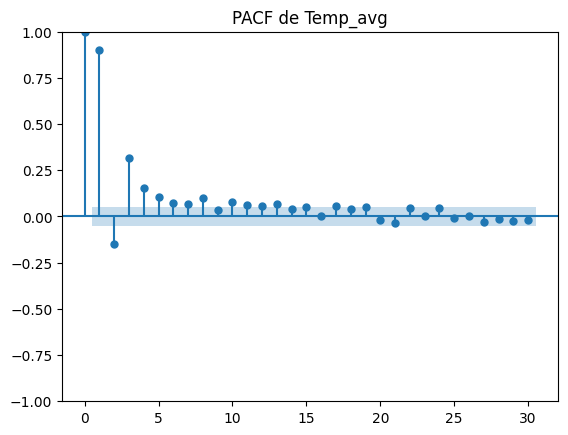

<Figure size 800x400 with 0 Axes>

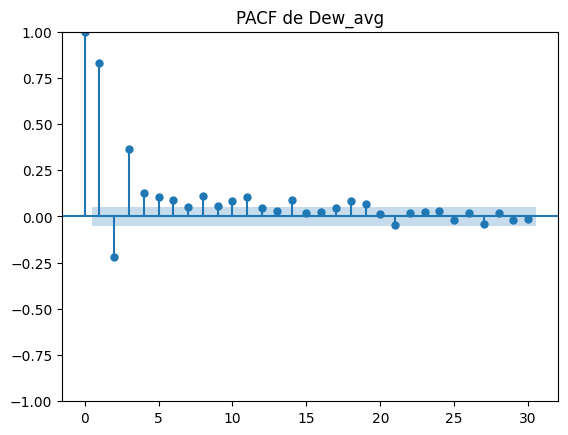

<Figure size 800x400 with 0 Axes>

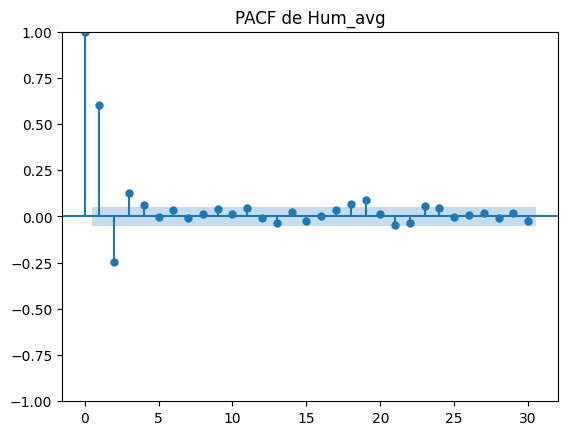

<Figure size 800x400 with 0 Axes>

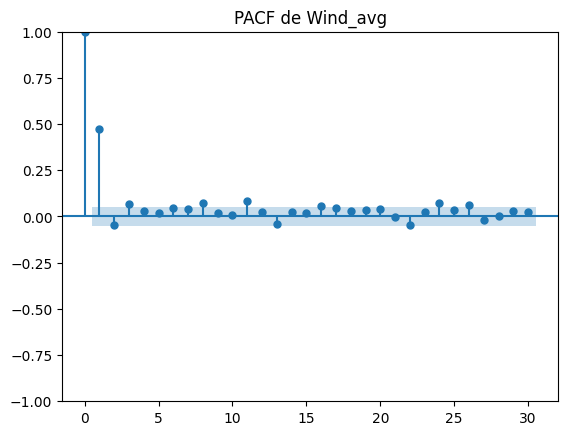

<Figure size 800x400 with 0 Axes>

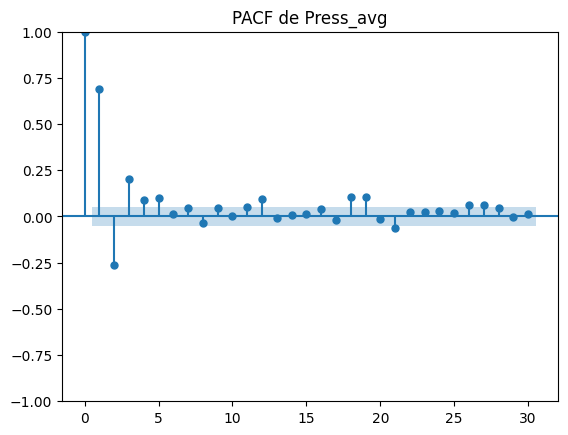

In [21]:
# Parte 1
# Lista de variables exógenas a analizar
regresores_avg = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']

# Calcular y graficar la PACF para cada variable exógena
for reg in regresores_avg:
    plt.figure(figsize=(8, 4))
    plot_pacf(df_train[reg], lags=30, method='ywm')
    plt.title(f'PACF de {reg}')
    plt.show()

Los lags seleccionados para cada variable exógena se basan en los valores significativos de las gráficas PACF. Para **Temp_avg**, **Dew_avg**, **Wind_avg** y **Press_avg**, se aplicarán lags de hasta 3 días, mientras que para **Hum_avg**, se aplicarán rezagos de 1 y 2 días.

In [22]:
# Parte 2 y 3

# Definir los lags para cada variable según lo determinado en el análisis PACF
lags_variables = {
    'Temp_avg': [1, 2, 3],
    'Dew_avg': [1, 2, 3],
    'Hum_avg': [1, 2],
    'Wind_avg': [1, 2, 3],
    'Press_avg': [1, 2, 3]
}

# Aplicar los lags a cada variable y agregarlos al conjunto de entrenamiento y prueba
for var, lags in lags_variables.items():
    for lag in lags:
        df_train[f'{var}_lag{lag}'] = df_train[var].shift(lag)
        df_test[f'{var}_lag{lag}'] = df_test[var].shift(lag)

# Imputar valores nulos con la media de cada columna
for var, lags in lags_variables.items():
    for lag in lags:
        # Para el conjunto de entrenamiento
        df_train[f'{var}_lag{lag}'] = df_train[f'{var}_lag{lag}'].fillna(df_train[f'{var}_lag{lag}'].mean())
        # Para el conjunto de prueba
        df_test[f'{var}_lag{lag}'] = df_test[f'{var}_lag{lag}'].fillna(df_test[f'{var}_lag{lag}'].mean())

In [23]:
# Parte 4

# Crear el modelo Prophet
m = Prophet()

# Añadir las variables exógenas originales al modelo
regresores_avg = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']
for reg in regresores_avg:
    m.add_regressor(reg)

# Añadir los lags de las variables exógenas al modelo
for var, lags in lags_variables.items():
    for lag in lags:
        m.add_regressor(f'{var}_lag{lag}')

# Entrenar el modelo con las variables exógenas originales y sus lags en el conjunto de entrenamiento
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/liagv7a6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzmnz4h5/orjnus7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39643', 'data', 'file=/tmp/tmpqzmnz4h5/liagv7a6.json', 'init=/tmp/tmpqzmnz4h5/orjnus7d.json', 'output', 'file=/tmp/tmpqzmnz4h5/prophet_modelvvicob6x/prophet_model-20241021021006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:10:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:10:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


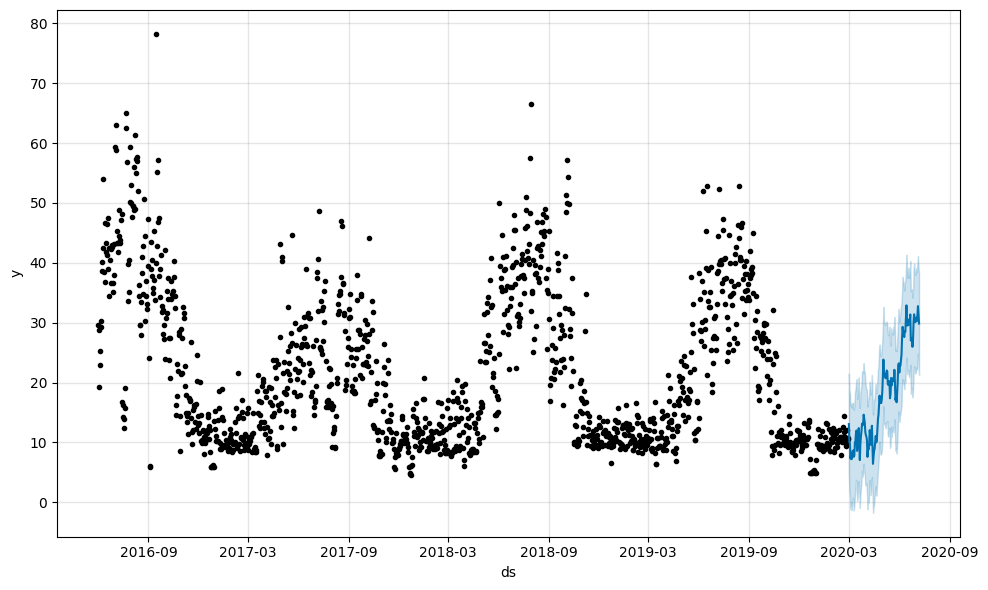

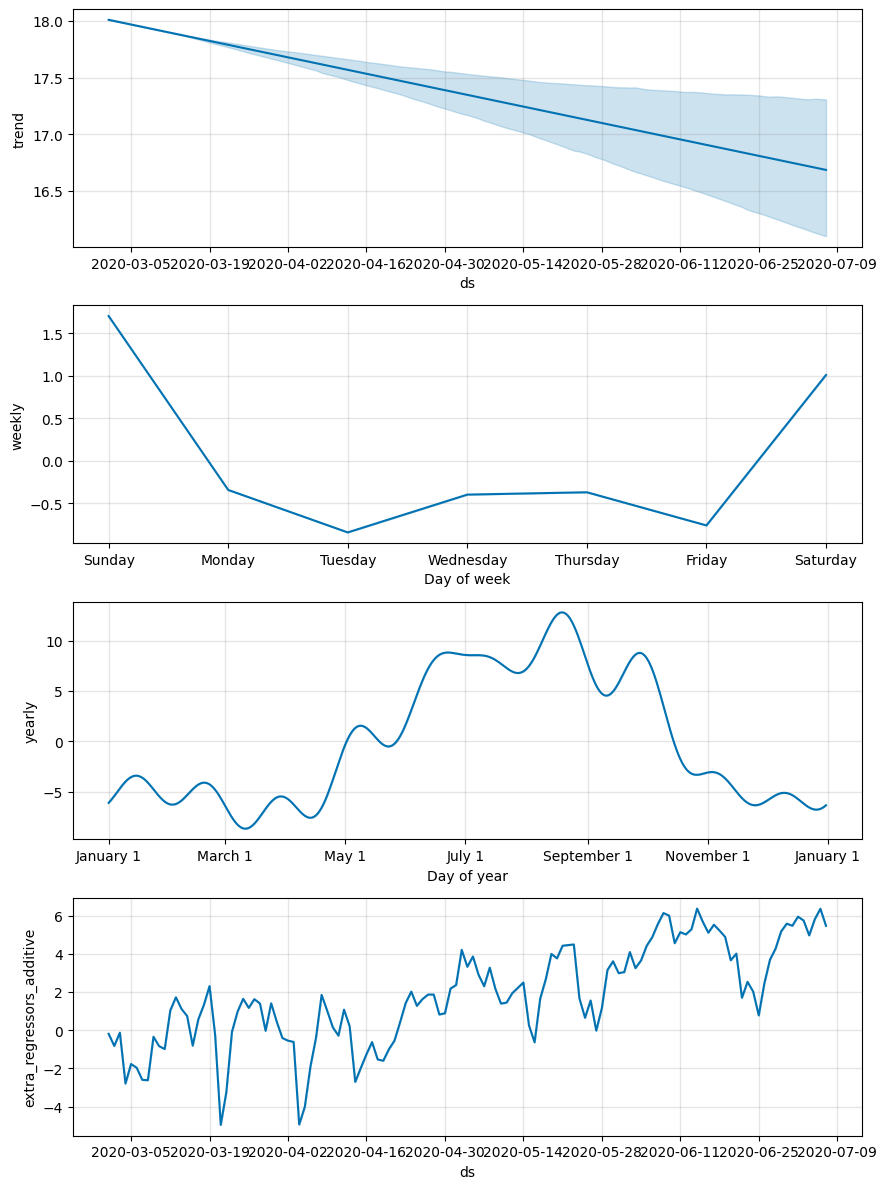

In [24]:
# Parte 5
# Realizar predicciones para el conjunto de prueba
future_test = df_test[['ds'] + regresores_avg + [f'{var}_lag{lag}' for var in lags_variables for lag in lags_variables[var]]]
forecast_test = m.predict(future_test)

# Graficar las predicciones
fig1 = m.plot(forecast_test)
fig1.show()

# Graficar las componentes del modelo (tendencia, estacionalidad y efecto de los regresores)
fig2 = m.plot_components(forecast_test)
fig2.show()

In [25]:
# Parte 6
# Predicciones en el conjunto de entrenamiento
future_train = df_train[['ds'] + regresores_avg + [f'{var}_lag{lag}' for var in lags_variables for lag in lags_variables[var]]]
forecast_train = m.predict(future_train)

# Calcular el MAE para el conjunto de entrenamiento
mae_train = mean_absolute_error(df_train['y'], forecast_train['yhat'])
print(f"MAE en el conjunto de entrenamiento: {mae_train}")

# Calcular el MAE para el conjunto de prueba
mae_test = mean_absolute_error(df_test['y'], forecast_test['yhat'])
print(f"MAE en el conjunto de prueba: {mae_test}")

MAE en el conjunto de entrenamiento: 4.679821166328378
MAE en el conjunto de prueba: 4.4881777432398


In [26]:
# Parte 7

# Calcular el error en el conjunto de entrenamiento
df_train['error'] = df_train['y'] - forecast_train['yhat']

# Calcular el error en el conjunto de prueba
df_test['error'] = df_test['y'] - forecast_test['yhat']

# Añadir una columna para identificar los conjuntos
df_train['set'] = 'Entrenamiento'
df_test['set'] = 'Prueba'

# Concatenar los DataFrames de entrenamiento y prueba
df_full = pd.concat([df_train, df_test])

# Graficar el error combinado
fig_error_combined = px.line(df_full, x='ds', y='error', color='set',
                             labels={'ds': 'Fecha', 'error': 'Error (kWh)', 'set': 'Conjunto'},
                             title='Error (Valor Real - Valor Predicho) en Entrenamiento y Prueba')
fig_error_combined.show()

La estacionalidad sigue presente al haber mayor dispersión de errores en torno a los meses de julio. Incluir Lags reduce el MAE, por lo que incluirlos ayuda al modelo a comprender mejor la naturaleza de los datos.

## 1.6 Optimizando Prophet [6 puntos]

<center>
<img src ="https://i.gifer.com/BKlg.gif" width = 500 />

Homero, contento con sus resultados, decide compartir su trabajo en LinkedIn. Sin embargo, justo antes de realizar la publicación, su hija Lisa Simpson le comenta que su modelo podría mejorar aún más mediante la optimización de hiperparámetros. Aunque Homero no entiende muy bien a qué se refiere Lisa, decide confiar en su conocimiento y le pide ayuda para implementar la optimización.

Lisa le prepara una función llamada optimize_prophet, que recibe como entrada el registro histórico, los datos a predecir (futuros), el nombre de las variables exógenas y una grilla de hiperparámetros que se desea modificar.

Después de varios intentos, Homero no logra utilizar la función de Lisa y, desesperado por publicar sus resultados en internet, se acerca a usted en busca de ayuda.

Para ello, usted decide realizar los siguientes pasos:

1. Crear una grilla donde se modifiquen los siguientes hiperparámetros: `changepoint_prior_scale`, `seasonality_prior_scale`, `seasonality_mode`, `changepoint_range` y encuentre los hiperparámetros que optimicen el `MAE`. `Nota:` Utilice la función `optimize_prophet()` dada en el enunciado. [1 punto]
2. Crear y entrenar un modelo Prophet utilizando los mejores parámetros encontrados, incluyendo regresores (variables exógenas). [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y en el de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en ambos conjuntos. Analice sus resultados. [1 punto]


In [27]:
#NO MODIFICAR ESTA CELDA

import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging

# Silenciar el logging de Prophet
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)


def optimize_prophet(df, df_to_pred, features, param_grid ):
  '''
  Función que recibe como entrada:
  -df: data entrenamiento.
  -df_to_pred: data a predecir (test).
  -features: lista de variables exógenas.
  -param_grid: grilla de hiperparámetros.

  Retorna:
  -tuning_results: Dataframe con resultados de la optimización.
  -best_params: Diccionario de mejores parámetros encontrados.
  '''

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  MAEs = []  # Store the MAEs for each params here

  # Use tqdm to add a progress bar to the parameter tuning loop
  for params in tqdm(all_params, desc="Tuning Prophet parameters"):
      m = Prophet(**params)  # Fit model with given params
      for feature in features:
          m.add_regressor(feature)
      m.fit(df)

      # Prepare future dataframe
      df_prop = m.make_future_dataframe(periods=len(df_to_pred))
      df_feat = pd.concat([df[features], df_to_pred[features]]).reset_index(drop=True)
      df_prop[features] = df_feat[features]

      # Make predictions
      forecast = m.predict(df_prop)
      forecast_pred = forecast[forecast['ds'].isin(df_to_pred['ds'])].reset_index(drop=True)

      # Calculate MAE for the predictions
      mae_pred = mean_absolute_error(df_to_pred['y'], forecast_pred['yhat'])
      MAEs.append(mae_pred)

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['MAEs'] = MAEs
  tuning_results = tuning_results.sort_values(by='MAEs', ascending=True)
  best_params = all_params[np.argmin(MAEs)]
  return tuning_results, best_params

**Respuesta:**

In [28]:
# Parte 1
# Definir la grilla de hiperparámetros para optimizar
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],  # Ajuste para la sensibilidad a los puntos de cambio en la tendencia
    'seasonality_prior_scale': [1.0, 5.0, 10.0],  # Ajuste para el nivel de suavidad de las componentes estacionales
    'seasonality_mode': ['additive', 'multiplicative'],  # Modo de estacionalidad: aditiva o multiplicativa
    'changepoint_range': [0.8, 0.9]  # Proporción del rango temporal para posibles puntos de cambio
}

# Definir las variables exógenas (regresores) utilizadas en el modelo
features = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']

# Realizar la optimización de hiperparámetros utilizando la función optimize_prophet
tuning_results, best_params = optimize_prophet(df_train, df_test, features, param_grid)

# Mostrar los resultados de la optimización
print("Resultados de la optimización:")
print(tuning_results)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros:")
print(best_params)

Tuning Prophet parameters: 100%|██████████| 36/36 [00:39<00:00,  1.09s/it]

Resultados de la optimización:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
24                     0.50                      1.0         additive   
2                      0.01                      1.0   multiplicative   
28                     0.50                      5.0         additive   
3                      0.01                      1.0   multiplicative   
6                      0.01                      5.0   multiplicative   
10                     0.01                     10.0   multiplicative   
11                     0.01                     10.0   multiplicative   
7                      0.01                      5.0   multiplicative   
9                      0.01                     10.0         additive   
1                      0.01                      1.0         additive   
32                     0.50                     10.0         additive   
5                      0.01                      5.0         additive   
0                   

In [29]:
# Parte 2

# Mejores parámetros encontrados
best_params = {
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 1.0,
    'seasonality_mode': 'additive',
    'changepoint_range': 0.8
}

# Crear el modelo Prophet con los mejores parámetros
m_best = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_range=best_params['changepoint_range']
)

# Añadir los regresores
regresores_avg = ['Temp_avg', 'Dew_avg', 'Hum_avg', 'Wind_avg', 'Press_avg']

for reg in regresores_avg:
    m_best.add_regressor(reg)

# Entrenar el modelo con los datos de entrenamiento que incluyen las variables exógenas
m_best.fit(df_train)

# Predicciones sobre el conjunto de prueba
future_test = df_test[['ds'] + regresores_avg]
forecast_test = m_best.predict(future_test)

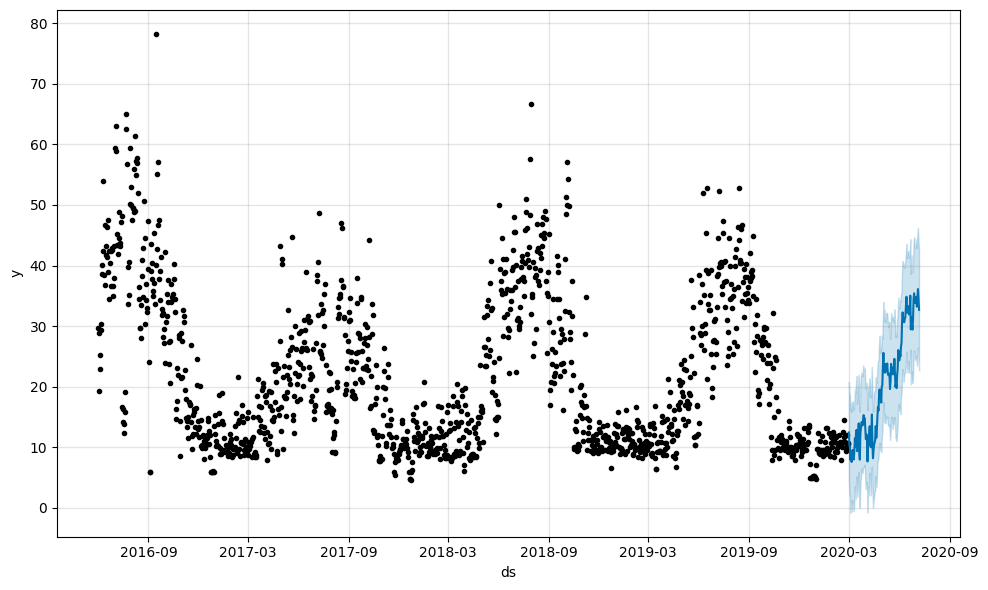

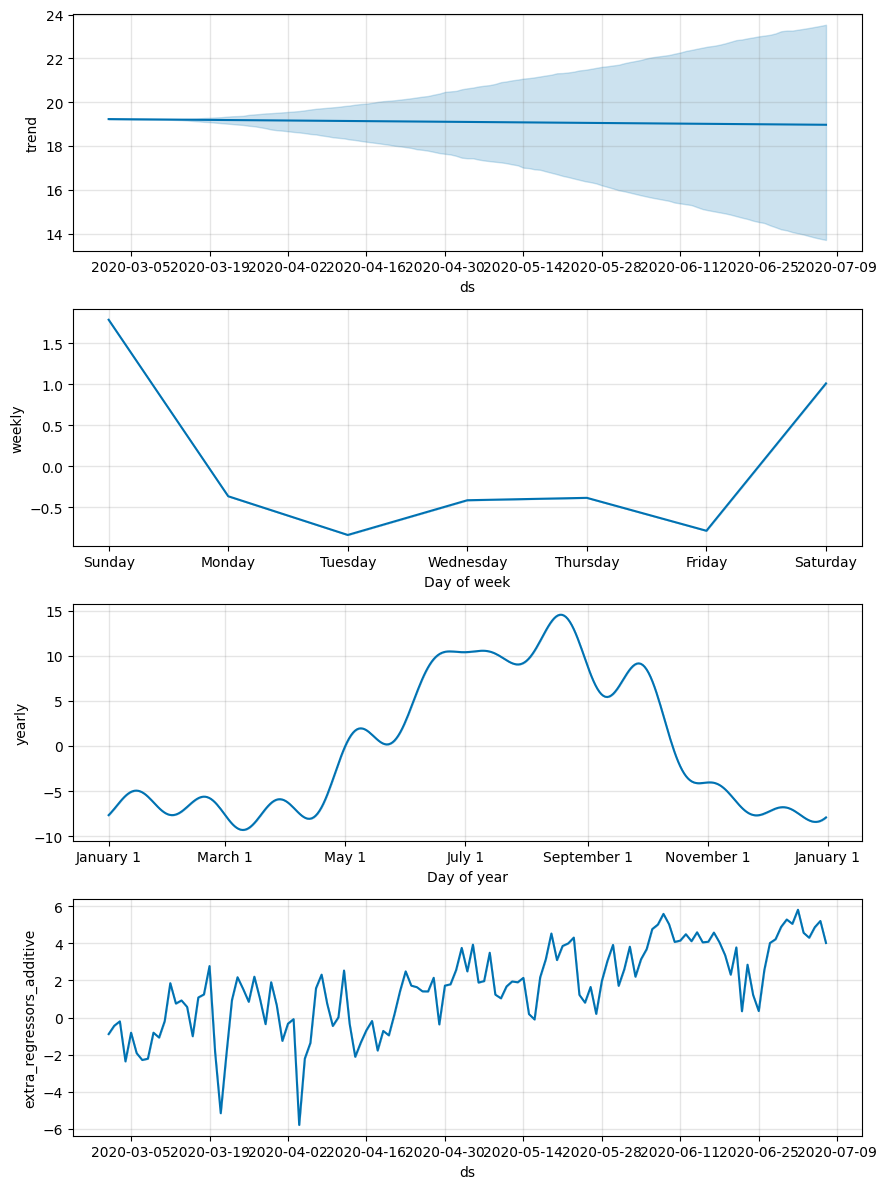

In [30]:
# Parte 3
# Graficar las predicciones del modelo Prophet
fig1 = m_best.plot(forecast_test)
fig1.show()

# Graficar las componentes del modelo Prophet
fig2 = m_best.plot_components(forecast_test)
fig2.show()

In [31]:
# Parte 4
# Predicciones en el conjunto de entrenamiento
future_train = df_train[['ds'] + regresores_avg]
forecast_train = m_best.predict(future_train)

# Calcular el MAE para el conjunto de entrenamiento
mae_train = mean_absolute_error(df_train['y'], forecast_train['yhat'])
print(f"MAE en el conjunto de entrenamiento: {mae_train}")

# Calcular el MAE para el conjunto de prueba
mae_test = mean_absolute_error(df_test['y'], forecast_test['yhat'])
print(f"MAE en el conjunto de prueba: {mae_test}")

MAE en el conjunto de entrenamiento: 4.561511486767541
MAE en el conjunto de prueba: 4.034457430527605


In [32]:
# Parte 5
# Calcular el error en el conjunto de entrenamiento
df_train['error'] = df_train['y'] - forecast_train['yhat']

# Calcular el error en el conjunto de prueba
df_test['error'] = df_test['y'] - forecast_test['yhat']

# Añadir una columna para identificar los conjuntos
df_train['set'] = 'Entrenamiento'
df_test['set'] = 'Prueba'

# Concatenar los conjuntos de entrenamiento y prueba
df_full = pd.concat([df_train, df_test])

# Graficar el error combinado
fig_error_combined = px.line(df_full, x='ds', y='error', color='set',
                             labels={'ds': 'Fecha', 'error': 'Error (kWh)', 'set': 'Conjunto'},
                             title='Error (Valor Real - Valor Predicho) en Entrenamiento y Prueba')
fig_error_combined.show()

Esta optimización ayudó al modelo a reducir aún más su MAE. Gracias a esto, los errores parecen tener una dispersión menor, aunque se mantiene la dispersión mayor en los meses de julio.

# **2. Sistemas de Recomendación (30 puntos)**

## Homero contra la Prohibición

<center>
<img src ="https://i.ytimg.com/vi/rMSXXuhZjYY/maxresdefault.jpg" width = 500 />

En Springfield, el caos estalló cuando las autoridades prohibieron el alcohol. Pero como siempre, donde otros ven problemas, Homero Simpson ve oportunidades. Decidido a mantener las fiestas vivas, se convirtió en el Barón de la Cerveza en un abrir y cerrar de ojos. Con la ayuda de su buen amigo Moe el cantinero, Homero obtuvo un valioso dataset llamado `cervezas.csv`, que contiene valoraciones de los ciudadanos de Springfield sobre distintas cervezas. Homero quiere asegurarse de ofrecer las cervezas más apreciadas para mantener a su clientela oculta y feliz, mientras eludía la mirada del estricto Elio Pez. Por ende, Homero lo contacta para solicitar de su ayuda en esta nueva labor.

El dataset contiene los siguientes atributos:

  * userId: Identificador de los ciudadanos/usuarios
  * beerId: Identificador único de cada cerveza
  * rating: Evaluación otorgada por el ciudadano a la cerveza, en un rango de 1.0 a 5.0.
  * beerName: Nombre de la cerveza
  * beerStyle: Tipo de Cerveza.



In [33]:
# Librerias extras
from sklearn.preprocessing import LabelEncoder

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.accuracy import mae
from surprise import NMF
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
import random


import pandas as pd
from copy import deepcopy

## Carga de los datos [0 puntos]

Cargue el dataset `cervezas.csv` y realice una breve exploración de los datos. ¿Hay valores nulos? ¿Cuantos cervezas se estan evaluando? ¿Cuantos ciudadanos participaron de esta evaluación?

In [34]:
data = pd.read_csv('/cervezas.csv')

data.head()

,userId,beerId,rating,beerName,beerStyle
0,144,995,3.0,Mai Bock,Maibock / Helles Bock
1,63,58695,4.0,Hop In The Dark Cascadian Dark Ale,American Black Ale
2,147,4083,5.0,Stone Ruination IPA,American Double / Imperial IPA
3,4261,40310,3.0,Noël Des Géants,Herbed / Spiced Beer
4,140,1904,5.0,Sierra Nevada Celebration Ale,American IPA


In [35]:
# Exploración de los datos
nulos = data.isnull().sum()
num_cervezas = data['beerId'].nunique()
num_ciudadanos = data['userId'].nunique()

nulos, num_cervezas, num_ciudadanos

(userId       0
 beerId       0
 rating       0
 beerName     0
 beerStyle    0
 dtype: int64,
 3747,
 706)

No hay valores nulos en ninguna de las columnas del dataset. Se están evaluando 3747 cervezas y participaron 706 ciudadanos.


## 2.1 Caracterización Inicial [3 puntos]

Antes de entrenar nuestro sistema recomendador, es necesario caracterizar los datos disponibles y de esta manera tener un mejor entendimiento del problema a resolver. Para esto, se le pide lo siguiente:

1. Genere gráficos y/o estadística descriptiva con los datos. Utilice su análisis para responder las siguientes preguntas: [2 puntos]
  - ¿Cuantos *usuarios* hay en los datos?
  - ¿Cuantos *productos* hay en los datos?
  - ¿Cuantas *calificaciones* hay en los datos?
  - ¿Cuantas *calificaciones* faltantes hay en los datos?
  - ¿Cual es la media de las *calificaciones* entregadas por los usuarios? ¿Cómo cambia esto a través de los productos?  
2. Transforme los datos entregados a una matriz (usuario, producto) y muestre sus resultados. [1 punto]

In [36]:
# Parte 1
num_ciudadanos = data['userId'].nunique()
num_cervezas = data['beerId'].nunique()
num_calificaciones = data['rating'].count()
num_calificaciones_faltantes = data['rating'].isnull().sum()
media_calificaciones = data['rating'].mean()
media_por_producto = data.groupby('beerName')['rating'].mean()

num_ciudadanos, num_cervezas, num_calificaciones, num_calificaciones_faltantes, media_calificaciones

(706, 3747, 295059, 0, 3.8603669096689135)

In [37]:
media_por_producto.sort_values(ascending=False)

,rating
beerName,
Citra DIPA,4.669492
Trappist Westvleteren 12,4.666129
Cantillon Blåbær Lambik,4.654762
Live Oak HefeWeizen,4.639706
Heady Topper,4.639344
...,...
Budweiser Select 55,1.919355
Budweiser Chelada,1.828571
Wild Blue (Blueberry Lager),1.818182


- Hay 706 usuarios.
- Hay 3747 productos.
- Hay 295059 calificaciones.
- No hay datos faltantes en las calificaciones.
- La media de las califaciones es de 3.86 y se puede observar que la cerveza mejor calificada es "Citra DIPA" con una calificaión de 4.67,  mientras que la peor es la "Crazy Ed's Cave Creek Chili Beer" con una calificaión de 1.38.

In [38]:
# Parte 2
# Transformamos los datos a una matriz (usuario, producto)
data_pivot = data.pivot_table(index='userId', columns='beerName', values='rating')

# Mostrar la matriz resultante
data_pivot

beerName,"""Shabadoo"" Black & Tan Ale",# 100,#9,'t Gaverhopke Extra,'t Smisje Calva Reserva,(512) Pecan Porter,10 Commandments,10 Squared Fish Tale Ale,10.0,1000 IBU,...,Žatec,§ucaba (Abacus),Édition 2005,Éphémère (Apple),Éphémère (Cassis / Black Currant),Éphémère (Cranberry),Équinoxe Du Printemps,Ølfabrikken Porter,Über Pils,ÜberSun (Imperial Summer Wheat Beer)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2 Método Basado en Contenido [4 puntos]

<center>
<img src ="https://is1-ssl.mzstatic.com/image/thumb/WfNa_TwFpJoTWXQmU-BrbA/1200x675.jpg" width = 500 />

Como primera tarea, Homero le pide centrarse en las características de las cervezas y no en la interacción de los ciudadanos con esta. Adicionalmente, Homero esta buscando nuevas cervezas para su consumo personal, donde usted pudo notar que Homero esta identificado como `userId = 100` en el dataset. Por ende, Homero le pide las siguientes acciones:

1. Cree un dataframe que contenga las características de las cervezas, excluyendo las evaluaciones de los ciudadanos. `Nota:` No considere valores duplicados. [1 punto]
2. Implemente el método Bag of Words para procesar la columna `beerStyle`. Para ello, transforme las palabras a minúsculas, elimine stopwords en inglés y filtre las palabras que aparezcan en 10 documentos como mínimo. Guarde su resultado como un DataFrame. [1 punto].
> `Nota:` Le puede ser útil esta [documentacion](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) y el método `.get_feature_names_out()`.
3. Cree una función que imprima las top 5 cervezas similares a `Chocolate Porter`, utilizando como medida de similitud la similitud coseno. [1 punto]
4. Identifique la cerveza mejor evaluada por Homero (`userId = 100`) y obtenga las top 5 cervezas similares a esa cerveza. [1 punto]

**Respuesta:**

In [39]:
# Parte 1
cerveza_caracteristicas = data[['beerId', 'beerName', 'beerStyle']].drop_duplicates()
cerveza_caracteristicas = cerveza_caracteristicas.reset_index(drop=True)

cerveza_caracteristicas.head()

,beerId,beerName,beerStyle
0,995,Mai Bock,Maibock / Helles Bock
1,58695,Hop In The Dark Cascadian Dark Ale,American Black Ale
2,4083,Stone Ruination IPA,American Double / Imperial IPA
3,40310,Noël Des Géants,Herbed / Spiced Beer
4,1904,Sierra Nevada Celebration Ale,American IPA


In [40]:
# Parte 2
# Definir el corpus de la columna 'beerStyle'
corpus = cerveza_caracteristicas['beerStyle'].str.lower()

# Crear un vectorizador para aplicar el método Bag of Words, eliminando stopwords en inglés
vectorizer = CountVectorizer(stop_words='english', min_df=10)

# Ajustar el vectorizador a los datos y transformar el corpus
X = vectorizer.fit_transform(corpus)

# Convertir el resultado en un DataFrame con las palabras como columnas
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bow_df.head()

,adjunct,ale,altbier,amber,american,apa,baltic,barleywine,beer,belgian,...,vienna,warmer,wee,weizenbock,wheat,wheatwine,wild,winter,witbier,zwickel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Parte 3
from sklearn.metrics.pairwise import cosine_similarity

def top_similares(cerveza, cerveza_caracteristicas, n_top=5):
    # Verificamos si la cerveza está en el DataFrame
    assert cerveza in cerveza_caracteristicas['beerName'].values, f"La cerveza '{cerveza}' no se encuentra en el DataFrame."

    # Convertimos las columnas categóricas en variables dummy
    cerveza_caracteristicas_encoded = pd.get_dummies(cerveza_caracteristicas.drop(columns=['beerName']))

    # Calculamos la matriz de similitud del coseno entre todas las cervezas
    caracteristicas_matrix = cerveza_caracteristicas_encoded.values
    similitud = cosine_similarity(caracteristicas_matrix)

    # Obtenemos el índice de la cerveza seleccionada
    idx = cerveza_caracteristicas[cerveza_caracteristicas['beerName'] == cerveza].index[0]

    # Enumeramos y ordenamos las cervezas por similitud de mayor a menor, excluyendo la misma cerveza
    sim_scores = list(enumerate(similitud[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Seleccionamos las top N cervezas más similares, excluyendo la misma cerveza
    sim_scores = sim_scores[1:n_top+1]
    beer_indices = [i[0] for i in sim_scores]

    return cerveza_caracteristicas['beerName'].iloc[beer_indices].values


top_similares('Chocolate Porter', cerveza_caracteristicas)

array(["Walker's Reserve - Porter", 'Highland Oatmeal Porter',
       "Stoudt's Winter Ale (2008-2009)", 'Dark Side Vanilla Porter',
       'Founders Porter'], dtype=object)

In [42]:
# Parte 4
homero_reviews = data[data['userId'] == 100]

# Obtenemos la mejor evaluada por Homero
best_homero_cerveza = homero_reviews.loc[homero_reviews['rating'].idxmax(), 'beerName']

best_homero_cerveza


"McNeill's Extra Special Bitter"

In [43]:
# Ahora utilizamos la función anterior para obtener las top 5 cervezas similares a la mejor evaluada por Homero
top_similares(best_homero_cerveza, cerveza_caracteristicas)

array(['Extra Special Ale (ESA)', 'Sawtooth Ale', 'Bishops Finger',
       "Stoudt's Scarlet Lady ESB", 'Schlafly Winter ESB'], dtype=object)

## 2.3 Filtros Colaborativos [16 puntos]

<center>
<img src ="https://i.makeagif.com/media/2-08-2016/McmGFQ.gif" width = 400 />

Después de consolidarse como el Barón de la Cerveza en Springfield, Homero Simpson decidió llevar su negocio clandestino a otro nivel. Al ser el único proveedor de alcohol en la ciudad, quiere asegurarse de que cada cerveza que elabora sea de la mejor calidad posible. Para lograrlo, planea usar las evaluaciones pasadas que los ciudadanos de Springfield han registrado sobre las distintas cervezas. Inspirado por los consejos de su amigo Moe, Homero se enteró de que puede implementar un sistema de recomendación basado en filtros colaborativos.

Ahora, Homero necesita de su ayuda para diseñar y elaborar distintos sistemas de filtros colaborativos que le permitan continuar con su reinado cervecero.

### 2.3.1 Filtros Colaborativos Basados en Memoria [8 puntos]

Para este tipo de filtros, Homero le pide lo siguiente:

1. Transforme el DataFrame de `pandas` a Dataset de `surprise`. `Hint`: Utilice solamente los identificadores de ciudadano, cerveza y rating. ¿Importa el orden? [1 punto]
2. Genere un conjunto de entrenamiento y uno de prueba, asegurando que el 30% de los datos sea destinado al conjunto de prueba. No olvide fijar una semilla para garantizar reproducibilidad. [1 punto]
3. Entrene un modelo de **KNN basado en usuarios** utilizando la `similitud coseno`. Luego realice predicciones en el conjunto de prueba. `Nota`: Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/knn_inspired.html) [2 puntos]
4. Calcule el MAE (Mean Absolute Error) de las predicciones realizadas por el modelo y muestre las predicciones en un DataFrame para su análisis. `Nota:` Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.mae) [2 puntos]
5. Repita los pasos 3 y 4 pero utilizando un modelo de **KNN basado en los productos**. [2 puntos]

**Respuesta:**

In [44]:
# Parte 1
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['userId', 'beerId', 'rating']], reader)

data_surprise.raw_ratings[:1]

[(144, 995, 3.0, None)]

El orden de las columnas no afecta el proceso mientras tengas las tres columnas necesarias: userId, beerId, y rating, dado que Surprise espera tres columnas en el DataFrame, pero el orden en que estén dispuestas no cambia el resultado final porque Surprise asignará automáticamente la primera columna a userId, la segunda a beerId, y la tercera a rating.

In [45]:
# Parte 2
# Dividimos el dataset con el 70% para entrenamiento y el 30% para prueba
trainset, testset = train_test_split(data_surprise, test_size=0.3, random_state=1323)

n_train_ratings = trainset.n_ratings

n_test_ratings = len(testset)

print("Conjunto de entrenamiento:", n_train_ratings)
print("Conjunto de prueba:", n_test_ratings)

Conjunto de entrenamiento: 206541
Conjunto de prueba: 88518


In [46]:
# Parte 3
# Definir las opciones de similitud para usar coseno
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# Inicializar el algoritmo KNN con las opciones de similitud definidas
algo = KNNBasic(sim_options=sim_options)

# Entrenar el modelo
algo.fit(trainset)

# Realizar predicciones en el conjunto de prueba
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [47]:
# Parte 4
# Calcular el MAE de las predicciones
accuracy.mae(predictions)

# Convertir las predicciones a un DataFrame
# Cada predicción tiene los atributos: uid, iid, r_ui, est, details
pred_df = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
                       columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])

print(pred_df.head())

MAE:  0.4667
   userId  beerId  true_rating  predicted_rating
0     506    1426          3.0          3.150000
1     147    1160          4.5          4.287500
2    3818    9088          4.0          3.912500
3    3268    7675          4.0          3.875000
4    7944   20789          3.0          3.452381


In [48]:
# Parte 5
# Definir las opciones de similitud para usar coseno y basado en productos
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# Inicializar el algoritmo KNN con las opciones de similitud definidas
algo_item_based = KNNBasic(sim_options=sim_options)

# Entrenar el modelo
algo_item_based.fit(trainset)

# Realizar predicciones en el conjunto de prueba
predictions_item_based = algo_item_based.test(testset)

# Calcular el MAE de las predicciones
accuracy.mae(predictions_item_based)

# Convertir las predicciones a un DataFrame
pred_df_item_based = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions_item_based],
                                  columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])

print(pred_df_item_based.head())

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.4664
   userId  beerId  true_rating  predicted_rating
0     506    1426          3.0          3.150000
1     147    1160          4.5          4.287500
2    3818    9088          4.0          3.912500
3    3268    7675          4.0          3.875000
4    7944   20789          3.0          3.710039


### 2.3.2 Filtros Colaborativos Basados en Modelo [8 puntos]

Ahora Homero le pide que cambie el enfoque del tipo de filtro colaborativo a uno basado en modelo. Por ende, Homero le pide lo siguiente:

1. Entrene un modelo `NMF` , asegurándose de fijar la semilla para reproducibilidad. Luego genere predicciones para el conjunto de prueba. [2 puntos]
2. Calcule el MAE de las predicciones obtenidas y muestre los resultados de las predicciones en un DataFrame para su analisis. [1 punto]
3. Entrene un modelo `SVD` sobre el conjunto de entrenamiento. Posteriormente, genere las predicciones para el conjunto de prueba. [2 puntos]
4. Calcule el MAE de las predicciones y muestre los resultados de las predicciones en un DataFrame. [1 punto]
5. Compare los resultados de ambos modelos y seleccione el mejor a su criterio. Justifique. [2 puntos]

**Respuesta**

In [49]:
# Parte 1
# Inicializamos el modelo NMF con la semilla
nmf_algo = NMF(random_state=1323)

# Entrenamos el modelo
nmf_algo.fit(trainset)

# Generamos predicciones para el conjunto de prueba
predictions_nmf = nmf_algo.test(testset)

# Mostramos las primeras predicciones
pred_df_nmf = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions_nmf],
                           columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])

pred_df_nmf.head()

,userId,beerId,true_rating,predicted_rating
0,506,1426,3.0,3.411239
1,147,1160,4.5,4.243336
2,3818,9088,4.0,4.013558
3,3268,7675,4.0,3.611685
4,7944,20789,3.0,3.412270


In [50]:
# Parte 2
# Calcular el MAE de las predicciones
accuracy.mae(predictions_nmf)

# Convertir las predicciones a un DataFrame
pred_df_nmf = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions_nmf],
                           columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])

print(pred_df_nmf.head())

MAE:  0.4834
   userId  beerId  true_rating  predicted_rating
0     506    1426          3.0          3.411239
1     147    1160          4.5          4.243336
2    3818    9088          4.0          4.013558
3    3268    7675          4.0          3.611685
4    7944   20789          3.0          3.412270


In [51]:
# Parte 3
# Inicializamos el modelo SVD
svd_algo = SVD()

# Entrenamos el modelo
svd_algo.fit(trainset)

# Generamos predicciones para el conjunto de prueba
predictions_svd = svd_algo.test(testset)

# Mostramos las primeras predicciones en un DataFrame
pred_df_svd = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions_svd],
                           columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])


print(pred_df_svd.head())

   userId  beerId  true_rating  predicted_rating
0     506    1426          3.0          3.333990
1     147    1160          4.5          4.230396
2    3818    9088          4.0          4.007133
3    3268    7675          4.0          3.766986
4    7944   20789          3.0          3.442387


In [52]:
# Parte 4
# Calcular el MAE de las predicciones del modelo SVD
accuracy.mae(predictions_svd)

# Convertir las predicciones a un DataFrame
pred_df_svd = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions_svd],
                           columns=['userId', 'beerId', 'true_rating', 'predicted_rating'])

print(pred_df_svd.head())

MAE:  0.4635
   userId  beerId  true_rating  predicted_rating
0     506    1426          3.0          3.333990
1     147    1160          4.5          4.230396
2    3818    9088          4.0          4.007133
3    3268    7675          4.0          3.766986
4    7944   20789          3.0          3.442387


5. El modelo que consideramos mejor debido a que tiene menor MAE es el SVD, con un MAE de 0.4635, contra el de NMF que es 0.4834. Además SVD es muy eficaz en recomendaciones de productos, especialmente cuando hay un número significativo de usuarios y productos, lo que es bastante útil con el problema que se está tratando.

## 2.4 El Mejor Filtro Colaborativo [7 puntos]

<center>
<img src ="https://media.giphy.com/media/citBl9yPwnUOs/giphy.gif" width = 400 />

Homero Simpson desea perfeccionar y extender su sistema de recomendaciones para cervezas en Springfield. En esta fase, busca implementar técnicas que le permitan no solo predecir las preferencias de los ciudadanos, sino también evaluar métricas que midan la eficacia de sus recomendaciones. Con el objetivo de recomendar las mejores K cervezas para usuarios específicos, Homero buscará comprender mejor cómo optimizar su sistema y satisfacer a sus clientes.

Para ello, usted ayudará a Homero realizando las siguientes labores:

1. Implemente la función `get_top_n()` que le permita extraer las `N` mejores cervezas recomendadas para cada ciudadano utilizando las predicciones generadas por el mejor modelo seleccionado en la sección anterior. Luego obtenga las `3` mejores cervezas recomendadas para Homero (`userId = 100`). `Hint`: Para cada ciudadano, elimine las predicciones duplicadas. [2 puntos]
2. Realice predicciones de rating para 5 cervezas aleatorias no evaluadas por Homero, para estimar las calificaciones que Homero podría darles. [1 punto]
3. Calcule los promedios de `precisión@k` y el `recall@k` para `k=10` y `threshold = 3.5`. Analice sus resultados. ¿Es un buen modelo? `Hint:` Utilice la función dada `precision_recall_at_k(...)`. [1 punto]
4. Calcule la `precisión@k` y el `recall@k` para valores de `k` que varíen entre 3 y 25 con paso de 1 unidad. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `k`. [1 punto]
5. Calcule la `precisión@k` y el `recall@k` para valores de `threshold` que varíen entre 3.0 y 4.5, con paso de 0.1. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `threshold`. [1 punto]
6. Finalmente utilice el mejor modelo para estimar los ratings faltantes. Muestre sus resultados en una matriz (usuario, producto) sin valores nulos. [1 punto]



In [53]:
#NO MODIFICAR ESTA CELDA
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

**Respuesta:**

In [55]:
# Parte 1
# Función para obtener las N mejores cervezas recomendadas para cada usuario, eliminando duplicados
def get_top_n(predictions, df_cervezas, n):
    beer_map = dict(zip(df_cervezas['beerId'], df_cervezas['beerName']))

    top_n = defaultdict(list)

    # Iteramos sobre las predicciones para agruparlas por usuario
    for pred in predictions:
        user_id = pred.uid
        beer_id = pred.iid
        predicted_rating = pred.est

        beer_name = beer_map.get(beer_id, "Cerveza desconocida")

        # Asegurarnos de que no haya duplicados en las cervezas recomendadas
        if beer_name not in [beer for beer, _ in top_n[user_id]]:
            top_n[user_id].append((beer_name, predicted_rating))

    # Ordenamos las cervezas para cada usuario por la calificación predicha y seleccionamos las top N
    for user_id, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

    return top_n

# Obtenemos las 3 mejores cervezas para Homero (userId = 100)
top_n_predictions = get_top_n(predictions_svd, cerveza_caracteristicas, n=3)
homero_top_3 = top_n_predictions[100]

print("Las 3 mejores cervezas recomendadas para Homero:", homero_top_3)

Las 3 mejores cervezas recomendadas para Homero: [("McNeill's Firehouse Amber Ale", 4.031212938969749), ("McNeill's Extra Special Bitter", 3.9441650879678143), ("McNeill's Pullman's Porter", 3.8673487095050207)]


In [56]:
# Parte 2
# Identificar las cervezas que Homero ya evaluó
homero_rated_beers = set(data[data['userId'] == 100]['beerId'])

# Obtener todas las cervezas disponibles
all_beers = set(cerveza_caracteristicas['beerId'])

# Filtrar las cervezas que Homero no ha evaluado
unrated_beers = list(all_beers - homero_rated_beers)

# Seleccionar 5 cervezas aleatorias no evaluadas por Homero
random_beers = random.sample(unrated_beers, 5)

# Predecir las calificaciones para estas 5 cervezas
predictions_for_homero = []
for beer_id in random_beers:
    pred = svd_algo.predict(uid=100, iid=beer_id)
    predictions_for_homero.append((beer_id, pred.est))

beer_map = dict(zip(cerveza_caracteristicas['beerId'], cerveza_caracteristicas['beerName']))
predictions_for_homero_named = [(beer_map[beer_id], predicted_rating) for beer_id, predicted_rating in predictions_for_homero]

for beer_name, predicted_rating in predictions_for_homero_named:
    print(f"Cerveza: {beer_name}, Calificación estimada: {predicted_rating:.2f}")

Cerveza: Brown Angel, Calificación estimada: 3.85
Cerveza: Pick Axe IPA, Calificación estimada: 3.86
Cerveza: Gritty McDuff's Scottish Ale, Calificación estimada: 3.73
Cerveza: J.W. Lees Harvest Ale (Calvados Cask), Calificación estimada: 3.86
Cerveza: Fat Weasel Ale, Calificación estimada: 3.71


In [58]:
# Parte 3

# Aplicar la función de precisión y recall@k
precision_at_k, recall_at_k = precision_recall_at_k(predictions_svd, k=10, threshold=3.5)

# Calcular el promedio de precisión y recall
avg_precision = sum(precision_at_k.values()) / len(precision_at_k)
avg_recall = sum(recall_at_k.values()) / len(recall_at_k)

print(f"Promedio de Precisión@10: {avg_precision:.4f}")
print(f"Promedio de Recall@10: {avg_recall:.4f}")

Promedio de Precisión@10: 0.7332
Promedio de Recall@10: 0.3391


El modelo muestra una Precisión@10 de 0.7334, lo que indica que la mayoría de las cervezas recomendadas en el top 10 son relevantes, lo que lo convierte en un modelo preciso en sus recomendaciones. Sin embargo, el Recall@10 de 0.3391 sugiere que solo captura alrededor del 33.91% de las cervezas relevantes, lo que implica que, aunque el modelo es bueno seleccionando cervezas precisas, podría mejorar en descubrir más cervezas relevantes para los usuarios.

In [59]:
# Parte 4
# Calcular precisión@k y recall@k para valores de k entre 3 y 25
k_values = range(3, 26)
precision_k_list = []
recall_k_list = []

for k in k_values:
    precision_at_k, recall_at_k = precision_recall_at_k(predictions_svd, k=k, threshold=3.5)
    avg_precision = sum(precision_at_k.values()) / len(precision_at_k)
    avg_recall = sum(recall_at_k.values()) / len(recall_at_k)

    precision_k_list.append(avg_precision)
    recall_k_list.append(avg_recall)

In [60]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(k_values), y=precision_k_list, mode='lines+markers', name='Precisión@k'))

fig.add_trace(go.Scatter(x=list(k_values), y=recall_k_list, mode='lines+markers', name='Recall@k'))

fig.update_layout(
    title='Curvas de Precisión@k y Recall@k en función de k',
    xaxis_title='k',
    yaxis_title='Valor',
    legend_title='Métricas',
    template='plotly_dark'
)

fig.show()

El gráfico muestra que la precisión@k se mantiene alta y casi constante mientras que el recall@k aumenta a medida que k incrementa, lo que indica que el modelo captura más ítems relevantes cuando se recomiendan más opciones. Sin embargo, existe un equilibrio: a mayor k, se mejora el recall pero la precisión tiende a disminuir ligeramente. Este comportamiento es típico en sistemas de recomendación, donde aumentar el número de recomendaciones incrementa las oportunidades de capturar ítems relevantes, pero también reduce la precisión al incluir más ítems irrelevantes. La elección de k dependerá del objetivo entre maximizar precisión o recall.

In [61]:
# Parte 5
threshold_values = np.arange(3.0, 4.6, 0.1)

precision_threshold_list = []
recall_threshold_list = []

# Calcular precisión@10 y recall@10
k = 10  # Fijamos k=10
for threshold in threshold_values:
    precision_at_k, recall_at_k = precision_recall_at_k(predictions_svd, k=k, threshold=threshold)
    avg_precision = sum(precision_at_k.values()) / len(precision_at_k)
    avg_recall = sum(recall_at_k.values()) / len(recall_at_k)

    precision_threshold_list.append(avg_precision)
    recall_threshold_list.append(avg_recall)

fig = go.Figure()

fig.add_trace(go.Scatter(x=threshold_values, y=precision_threshold_list, mode='lines+markers', name='Precisión@k'))

fig.add_trace(go.Scatter(x=threshold_values, y=recall_threshold_list, mode='lines+markers', name='Recall@k'))

fig.update_layout(
    title='Curvas de Precisión@k y Recall@k en función de threshold',
    xaxis_title='Threshold',
    yaxis_title='Valor',
    legend_title='Métricas',
    template='plotly_dark'
)

fig.show()

El gráfico muestra que, a medida que el threshold aumenta, la precisión@k disminuye gradualmente y el recall@k cae de manera más pronunciada. Esto indica que, con umbrales más bajos, el modelo es más preciso y captura más ítems relevantes, pero al incrementar el threshold, el modelo se vuelve más exigente, reduciendo tanto la cantidad de predicciones relevantes como la capacidad de encontrar ítems relevantes. En general, umbrales más bajos permiten mejores resultados en términos de precisión y recall, mientras que umbrales más altos limitan la eficacia del modelo.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por el foro de U-cursos o por correo.

<center>
<img src ="https://i.gifer.com/origin/cb/cbd80e6045652ab123caffef72f29210_w200.gif" width = 400 />
